# Causal Games

This notebook walks through a few examples for building intuition about backdoor paths used in *The Book of Why* by Judea Pearl. 

For each example, we take an example causal graph represented as a *Directed Acyclic Graph* (DAG), and our goal is to identify the set of deconfounders (often denoted $Z$) that will close all backdoor (a.k.a biasing) paths from nodes $X$ to $Y$. A backdoor path is any undirected path from $ X $ to $ Y $ that starts with an arrow into $ X $, i.e., contains an edge pointing into $ X $.

In [1]:
# Imports

from pgmpy.base import DAG
from pgmpy.identification import Adjustment, Frontdoor

# Example 1

Although the following example is simple, many analysts include $ A $ and/or $ B $ *for good measure*. Because $ A $ lies on the path $ X \rightarrow A \rightarrow Y $, it is a mediator; conditioning on $ A $ closes this path and attenuates the estimated total effect of $ X $ on $ Y $.

<Axes: >

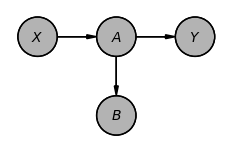

In [2]:
example1 = DAG([('X', 'A'),
            ('A', 'Y'),
            ('A', 'B')],
           roles={'exposure': 'X', 'outcome': 'Y'})

example1.to_daft(node_pos={'X': (0, 0), 'Y': (2, 0), 'A': (1, 0), 'B': (1, -1)}).render()

In [3]:
# @markdown Notice how there are no nodes with arrows pointing into X.  Said another way, X has no parents.  Therefore, there can't be any backdoor paths confounding X and Y.  pgmpy will confirm this in the following way:

needs_adjustment = Adjustment().validate(example1)
print(
    f"Are there any active backdoor paths? {not needs_adjustment}"
)

adjusted_graphs, success = Adjustment(variant="all").identify(example1)

print(f"No. of potential adjustment sets: {len(adjusted_graphs)}")

all_adjustment_sets = [str(graph.get_role('adjustment')) for graph in adjusted_graphs]
print(f"If so, what are the possible backdoor adjustment sets? {', '.join(all_adjustment_sets)}")

Are there any active backdoor paths? False
No. of potential adjustment sets: 1
If so, what are the possible backdoor adjustment sets? []


# Example 2

This graph is a bit more complex, but it is also trivial to solve.  The key is noticing that there is only one backdoor path between $ X $ and $ Y $, which goes from $ X \leftarrow A \rightarrow B \leftarrow D \rightarrow E \rightarrow Y $. However, as this path has a collider structure at $ B $ (a.k.a a 'V-Structure') because of $ A \rightarrow B \leftarrow D $, this path is *not active* and hence not a backdoor path.

<Axes: >

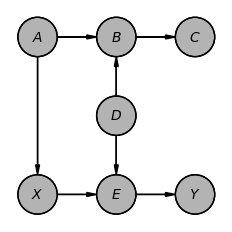

In [4]:
example2 = DAG([('X', 'E'), 
             ('A', 'X'), 
             ('A', 'B'), 
             ('B', 'C'), 
             ('D', 'B'), 
             ('D', 'E'), 
             ('E', 'Y')],
            roles={'exposure': 'X', 'outcome': 'Y'})

example2.to_daft(node_pos={'X': (1, 1), 'Y': (3, 1), 'A': (1, 3), 'B': (2, 3), 'C': (3, 3), 'D': (2, 2), 'E': (2, 1)}).render()

In [5]:
needs_adjustment = Adjustment().validate(example2)
print(
    f"Are there any active backdoor paths? {not needs_adjustment}"
)

adjusted_graphs, success = Adjustment(variant="all").identify(example2)

print(f"No. of potential adjustment sets: {len(adjusted_graphs)}")

all_adjustment_sets = [str(graph.get_role('adjustment')) for graph in adjusted_graphs]
print(f"If so, what are the possible backdoor adjustment sets? {', '.join(all_adjustment_sets)}")

adjusted_graph, success = Adjustment(variant="minimal").identify(example2)
print(f"What is the minimal possible backdoor adjustment set? {adjusted_graph.get_role('adjustment')}")

Are there any active backdoor paths? False
No. of potential adjustment sets: 4
If so, what are the possible backdoor adjustment sets? [], ['A'], ['D'], ['A', 'D']
What is the minimal possible backdoor adjustment set? []


# Example 3

This example actually requires adjustment, as it has open backdoor paths. The path $ X \leftarrow B \rightarrow Y $ is an open backdoor path in the DAG with $ B $ as the common cause for both $ X $ and $ Y $. The other path $ X \rightarrow A \leftarrow B \rightarrow Y $ is not active because of the V-Structure at $ A $. Hence, conditioning just on the variable $ B $ would block all backdoor paths.

<Axes: >

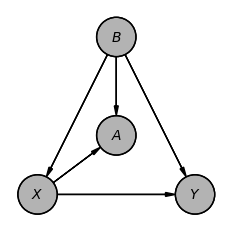

In [6]:
example3 = DAG([('X', 'Y'),
             ('X', 'A'),
             ('B', 'A'),
             ('B', 'X'),
             ('B', 'Y')],
            roles={'exposure': 'X', 'outcome': 'Y'})

example3.to_daft(node_pos={'X': (1, 1), 'Y': (3, 1), 'A': (2, 1.75), 'B': (2, 3)}).render()

In [7]:
needs_adjustment = Adjustment().validate(example3)
print(
    f"Are there any active backdoor paths? {not needs_adjustment}"
)

adjusted_graphs, success = Adjustment(variant="all").identify(example3)

print(f"No. of potential adjustment sets: {len(adjusted_graphs)}")

all_adjustment_sets = [str(graph.get_role('adjustment')) for graph in adjusted_graphs]
print(f"If so, what are the possible backdoor adjustment sets? {', '.join(all_adjustment_sets)}")

Are there any active backdoor paths? True
No. of potential adjustment sets: 1
If so, what are the possible backdoor adjustment sets? ['B']


# Example 4

This *DAG* structure is commonly known as the "M Bias" example because of the shape of the *DAG*. This is also a common example where classical analysts might want to adjust/control for the variable $ B $  as it is a pre-treatment variable. However, as we can see that the only backdoor path $ X \leftarrow A \rightarrow B \leftarrow C \rightarrow Y $ is not active due to the V-structure at $ B $. Hence, no adjustment is needed in this case. But if we adjust for the variable $ B $, it would activate the V-structure, making the path $ X \leftarrow A \rightarrow B \leftarrow C \rightarrow Y $ active.


<Axes: >

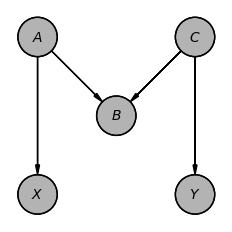

In [8]:
example4 = DAG([('A', 'X'),
             ('A', 'B'),
             ('C', 'B'),
             ('C', 'Y')],
            roles={'exposure': 'X', 'outcome': 'Y'})
example4.to_daft(node_pos={'X': (1, 1), 'Y': (3, 1), 'A': (1, 3), 'B': (2, 2), 'C': (3, 3)}).render()

In [9]:
needs_adjustment = Adjustment().validate(example4)
print(
    f"Are there any active backdoor paths? {not needs_adjustment}"
)

adjusted_graphs, success = Adjustment(variant="all").identify(example4)

print(f"No. of potential adjustment sets: {len(adjusted_graphs)}")

all_adjustment_sets = [str(graph.get_role('adjustment')) for graph in adjusted_graphs]
print(f"If so, what are the possible backdoor adjustment sets? {', '.join(all_adjustment_sets)}")

Are there any active backdoor paths? False
No. of potential adjustment sets: 4
If so, what are the possible backdoor adjustment sets? [], ['A'], ['C'], ['A', 'C']


# Example 5

This is the last example in The Book of Why. In this case, we have two backdoor paths, 
1. $ X \leftarrow A \rightarrow B \leftarrow C \rightarrow Y $
2. $ X \leftarrow B \leftarrow C \rightarrow Y $.

The first backdoor path is not active due to the V-structure at $ B $, however, the second one is active. To control for the second backdoor path, one option is to condition on the variable $ B $, but doing that makes the first backdoor path active, requiring additionally conditioning on $ A $ or $ C $. Another possibility is to simply condition on $ C $ which would block the second backdoor path without activating the first one.

<Axes: >

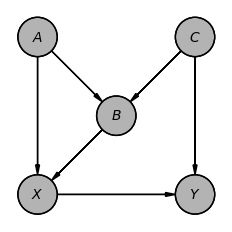

In [10]:
example5 = DAG([('A', 'X'),
             ('A', 'B'),
             ('C', 'B'),
             ('C', 'Y'),
             ('X', 'Y'),
             ('B', 'X')],
             roles={'exposure': 'X', 'outcome': 'Y'})

example5.to_daft(node_pos={'X': (1, 1), 'Y': (3, 1), 'A': (1, 3), 'B': (2, 2), 'C': (3, 3)}).render()

In [11]:
needs_adjustment = Adjustment().validate(example5)
print(
    f"Are there any active backdoor paths? {not needs_adjustment}"
)

adjusted_graphs, success = Adjustment(variant="all").identify(example5)

print(f"No. of potential adjustment sets: {len(adjusted_graphs)}")

all_adjustment_sets = [str(graph.get_role('adjustment')) for graph in adjusted_graphs]
print(f"If so, what are the possible backdoor adjustment sets? {', '.join(all_adjustment_sets)}")

Are there any active backdoor paths? True
No. of potential adjustment sets: 5
If so, what are the possible backdoor adjustment sets? ['C'], ['A', 'B'], ['A', 'C'], ['B', 'C'], ['A', 'B', 'C']


# Example 6

This example is drawn from Causality by Pearl on p. 80. This is similar to Example 5, but because $ D $ is now a common cause of $ X $ and $ Y $, it requires us to condition on $ D $. But similar to the last example, this leads to the activation of the other path $ X \leftarrow C \leftarrow A \rightarrow D \leftarrow B \rightarrow E \rightarrow Y $. To block this path, we will need to additionally condition on one of: $ C $, $ A $, $ B $, or $ E $.

<Axes: >

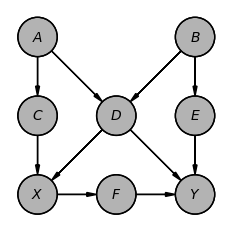

In [12]:
example6 = DAG([('X', 'F'),
             ('F', 'Y'),
             ('C', 'X'),
             ('A', 'C'),
             ('A', 'D'),
             ('D', 'X'),
             ('D', 'Y'),
             ('B', 'D'),
             ('B', 'E'),
             ('E', 'Y')],
            roles={'exposure': 'X', 'outcome': 'Y'})
example6.to_daft(node_pos={'X': (1, 1), 'Y': (3, 1), 'A': (1, 3), 'B': (3, 3), 'C': (1, 2), 'D': (2, 2), 'E': (3, 2), 'F': (2, 1)}).render()

In [13]:
needs_adjustment = Adjustment().validate(example6)
print(
    f"Are there any active backdoor paths? {not needs_adjustment}"
)

adjusted_graphs, success = Adjustment(variant="all").identify(example6)

print(f"No. of potential adjustment sets: {len(adjusted_graphs)}")

all_adjustment_sets = [str(graph.get_role('adjustment')) for graph in adjusted_graphs]
print(f"If so, what are the possible backdoor adjustment sets? {', '.join(all_adjustment_sets)}")

adjusted_graph, success = Adjustment(variant="minimal").identify(example6)
print(f"What is the minimal possible backdoor adjustment set? {adjusted_graph.get_role('adjustment')}")

Are there any active backdoor paths? True
No. of potential adjustment sets: 15
If so, what are the possible backdoor adjustment sets? ['D', 'E'], ['D', 'B'], ['A', 'D'], ['C', 'D'], ['D', 'B', 'E'], ['A', 'D', 'E'], ['C', 'D', 'E'], ['A', 'D', 'B'], ['C', 'D', 'B'], ['C', 'A', 'D'], ['A', 'D', 'B', 'E'], ['C', 'D', 'B', 'E'], ['C', 'A', 'D', 'E'], ['C', 'A', 'D', 'B'], ['C', 'A', 'D', 'B', 'E']
What is the minimal possible backdoor adjustment set? ['C', 'D']


# Example 7

This example shows an example where a backdoor adjustment is not possible. In this case, $ B $ is a latent variable and hence can not be conditioned on, making it impossible to block the backdoor path $ X \leftarrow B \rightarrow Y $. However, another criterion called the Frontdoor Criterion can be applied here to identify the effect of $ X $ on $ Y $.

<Axes: >

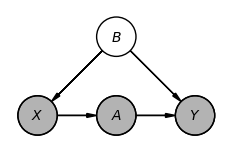

In [14]:
example7 = DAG([('X', 'A'), ('A', 'Y'), ('B', 'X'), ('B', 'Y')], latents={'B'}, roles={'exposure': 'X', 'outcome': 'Y'})
example7.to_daft(node_pos={'X': (1, 1), 'Y': (3, 1), 'A': (2, 1), 'B': (2, 2)}).render()

In [15]:
needs_adjustment = Adjustment().validate(example7)
print(
    f"Are there any active backdoor paths? {not needs_adjustment}"
)

adjusted_graphs, success = Adjustment(variant="all").identify(example7)
all_adjustment_sets = [str(graph.get_role('adjustment')) for graph in adjusted_graphs]
print(f"Are there any set of variables to block the backdoor paths? {success}")

adjusted_graph, success = Frontdoor().identify(example7)
print(f"Possible frontdoor adjustment variables?: {adjusted_graph.get_role('frontdoor')}")

Are there any active backdoor paths? True
Are there any set of variables to block the backdoor paths? False
Possible frontdoor adjustment variables?: ['A']
